Here I implement grovers algorithm. I am attempting to follow the [original paper](https://dl.acm.org/doi/pdf/10.1145/237814.237866) as closely as possible.

In [21]:
from qiskit import QuantumRegister, QuantumCircuit, quantum_info, circuit, visualization
import qiskit_aer as qa

import numpy as np
from numpy import fill_diagonal

In [22]:
def initialize_state(oracle_domain: int):
    """accepts an integer and returns a circuit
    that initializes an input state of state_space
    qubits into an equal superpositional state
    """


    # we first determine the number of qubits necessary
    # describe our state in base 2
    # ie if the oracle accepts any integer in [0,7]
    # we want to use 3 qubits
    # if it accepts any integer [0,5] we also want
    # to use 3 qubits since this can not be represented
    # by 2 clasical bits

    qubits_req = int(np.ceil(np.log2(oracle_domain)))
    print(qubits_req)
    ret_circ = QuantumCircuit(qubits_req)

    for i in range(qubits_req):
        ret_circ.h(i)

    return ret_circ

In [23]:
def diffusion_operator(big_n):
    # we construct the diffusion operator D as described in:
    # https://arxiv.org/pdf/quant-ph/9605043

    # at least 1 qubit is needed
    n = max(np.ceil(np.log2(big_n)), 1)

    nearest_power_of_2_above_big_n = 2 ** (n)

    operator = np.zeros((int(nearest_power_of_2_above_big_n), int(nearest_power_of_2_above_big_n)))

    operator.fill(2 / big_n)
    fill_diagonal(operator, -1 + 2 / big_n)

    return quantum_info.Operator(operator) 

In [24]:
def construct_groracle(true_value: int, max_value: int):
    if true_value >= max_value:
        raise Exception(
            f"{true_value} must be within [0, {max_value})"
        )
    
    return lambda x: x == true_value

def unitary_groracle(true_value: int, max_value: int):
    # constructs U_omega for omega = true_value within state space
    # of size max_value. 

    # ensure max_value is some int st max_value = 2 ^ k for some k
    # and i guess note that the true max will be 1 minus that value

    ret_mat = np.identity(max_value)

    # flip the sign. This is the construction from the paper, ie
    # C(S) = -|x> iff f(x) = 1
    # this works because the lexiograpic order works like we want it to :)
    # I think this is little endian...
    ret_mat[true_value, true_value] *= -1
    
    return quantum_info.Operator(ret_mat)

In [25]:
def build_algorithm(big_n: int, groracle):
    n = int(max(np.ceil(np.log2(big_n)), 1))

    iterations_to_perform = int(np.ceil(np.pi * .25 * np.sqrt(big_n)))

    diff_op = diffusion_operator(big_n)
    # diff_q_instruction = circuit.CircuitInstruction()
    
    circ = QuantumCircuit(n)

    for qubit in range(n):
        circ.h(qubit)

    for _ in range(iterations_to_perform):
        circ.append(groracle, list(range(n)))
        circ.append(diff_op, list(range(n)))

    circ.measure_all()

    return circ

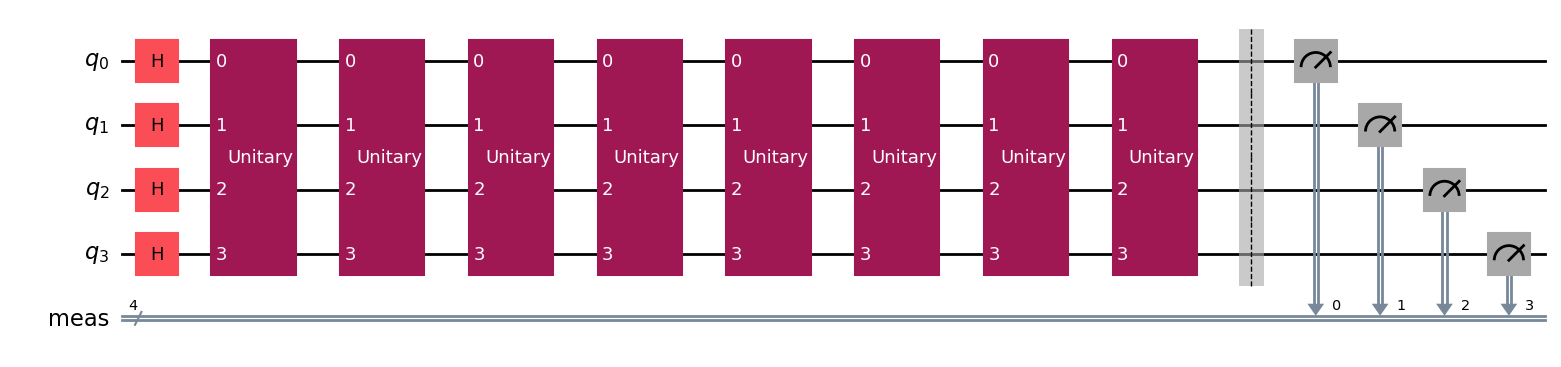

In [26]:
my_gror = unitary_groracle(7, 16)

circ = build_algorithm(16, my_gror)

circ.draw("mpl")

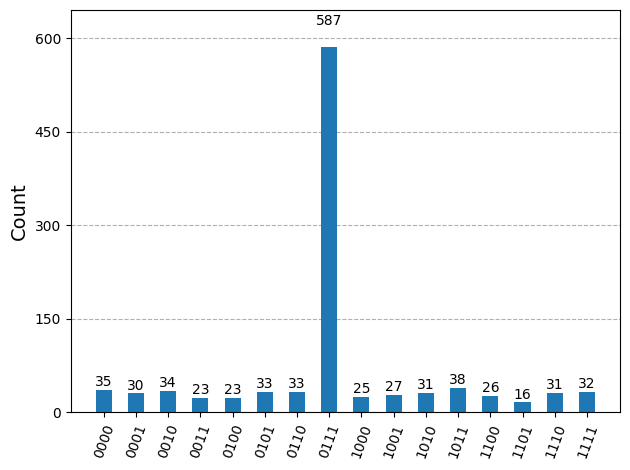

In [27]:
sampler = qa.AerSimulator()

my_test = transpile(circ, sampler)

result = sampler.run(my_test).result()

counts = result.get_counts(my_test)

visualization.plot_histogram(counts)